## Perform Simulation to Prove Markov Property

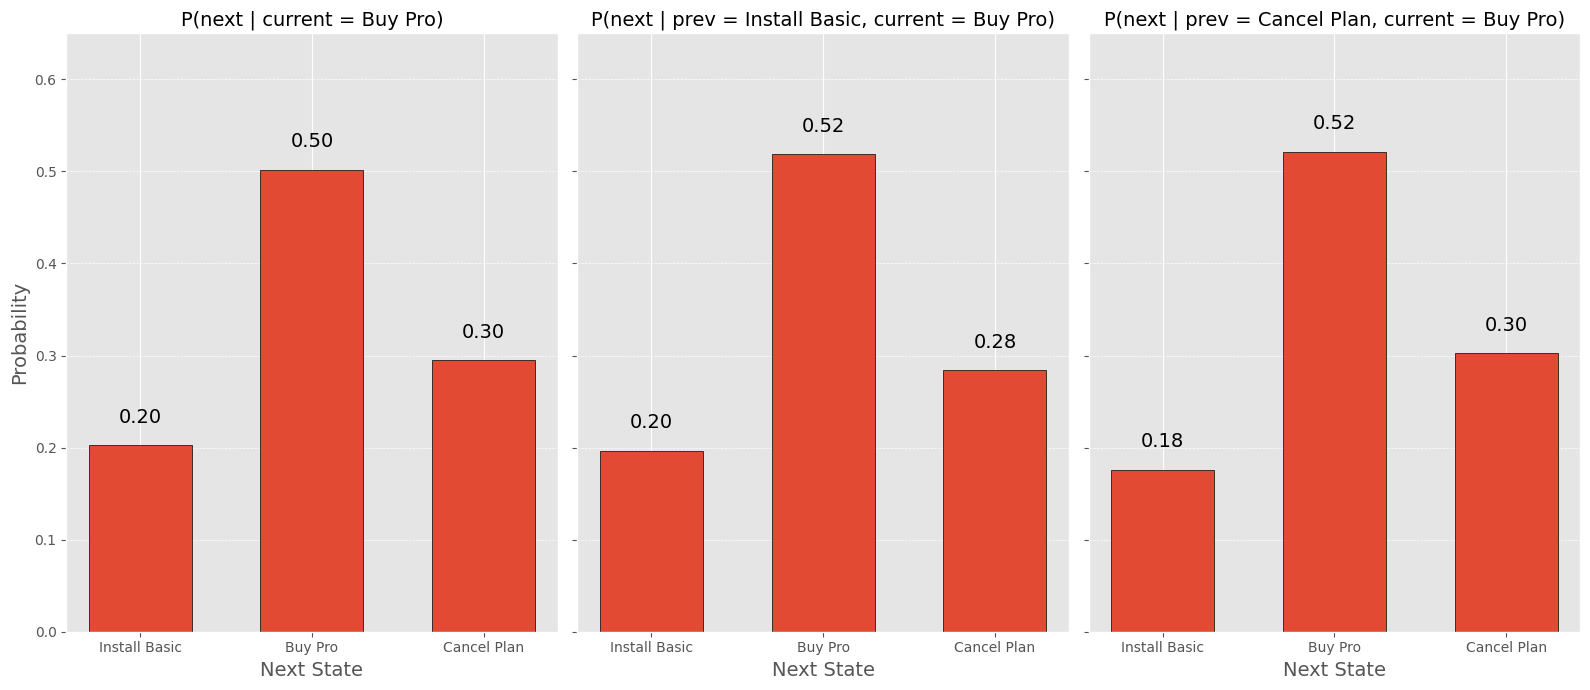

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# set seeds for reproducibility
np.random.seed(42)

# Use a built‑in style available by default
plt.style.use('ggplot')

def simulate_markov(P: NDArray[np.float64], initial_state: int, n_steps: int) -> NDArray[np.int_]:
    n_states: int = P.shape[0]
    chain: NDArray[np.int_] = np.empty(n_steps, dtype=int)
    chain[0] = initial_state
    for t in range(1, n_steps):
        chain[t] = np.random.choice(n_states, p=P[chain[t-1]])
    return chain

def empirical_distribution(next_states: NDArray[np.int_], n_states: int) -> NDArray[np.float64]:
    counts: NDArray[np.int_] = np.bincount(next_states, minlength=n_states)
    return counts / counts.sum()

# Setup
states: list[str] = ['Install Basic', 'Buy Pro', 'Cancel Plan']
P: NDArray[np.float64] = np.array([
    [0.6, 0.3, 0.1],
    [0.2, 0.5, 0.3],
    [0.3, 0.1, 0.6]
])
n_steps: int = 15_000
chain: NDArray[np.int_] = simulate_markov(P, initial_state=1, n_steps=n_steps)

# Compute distributions
dist_B: NDArray[np.float64] = empirical_distribution(chain[1:][chain[:-1] == 1], len(states))
dist_IB: NDArray[np.float64] = empirical_distribution(chain[2:][(chain[:-2] == 0)&(chain[1:-1] == 1)], len(states))
dist_CB: NDArray[np.float64] = empirical_distribution(chain[2:][(chain[:-2] == 2)&(chain[1:-1] == 1)], len(states))

titles: list[str] = [
    'P(next | current = Buy Pro)',
    'P(next | prev = Install Basic, current = Buy Pro)',
    'P(next | prev = Cancel Plan, current = Buy Pro)'
]
dists: list[NDArray[np.float64]] = [dist_B, dist_IB, dist_CB]

# Plot side by side
fig: Figure
axes: NDArray[Axes]
fig, axes = plt.subplots(1, 3, figsize=(16, 7), sharey=True)
plt.rcParams.update({
    "ytick.labelsize": 16,
    "xtick.labelsize": 16
})

for ax, title, dist in zip(axes, titles, dists):
    bars = ax.bar(states, dist, edgecolor='black', width=0.6)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Next State', fontsize=14)
    ax.set_ylim(0, 0.65)
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    for bar in bars:
        height: float = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=14)
axes[0].set_ylabel('Probability', fontsize=14)

plt.tight_layout()
plt.savefig('markov_plot.png', dpi=300, bbox_inches='tight')  # Saves high-resolution image
plt.show()


## Chi 2 statistical test for testing independency of states

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency
from numpy.typing import NDArray

# set seeds for reproducibility
np.random.seed(42)

# 1) Simulate the Markov chain again
states: list[str] = ['Install Basic', 'Buy Pro', 'Cancel Plan']
P_true: NDArray[np.float64] = np.array([
    [0.6, 0.3, 0.1],
    [0.2, 0.5, 0.3],
    [0.3, 0.1, 0.6]
])

n_steps: int = 10000
chain: NDArray[np.int_] = np.zeros(n_steps, dtype=int)
chain[0] = 1  # start from 'Medium'
for t in range(1, n_steps):
    chain[t] = np.random.choice(3, p=P_true[chain[t-1]])

# 2) Build contingency table of Prev vs Next given Current = Medium
# Rows: previous state; Columns: next state
contingency: NDArray[np.int_] = np.zeros((3, 3), dtype=int)
for t in range(2, n_steps):
    prev: int
    curr: int
    nxt: int
    prev, curr, nxt = chain[t-2], chain[t-1], chain[t]
    if curr == 1:  # only when current == 'Medium'
        contingency[prev, nxt] += 1

# 3) Perform chi-square test of independence
chi2_stat: float
p_value: float
dof: int
expected: NDArray[np.float64]
chi2_stat, p_value, dof, expected = chi2_contingency(contingency)

# 4) Display results
print("Contingency table (Prev vs Next | Current=Buy Pro):")
print(contingency)
print("\nExpected frequencies under independence:")
print(np.round(expected).astype(int))
print(f"\nChi-square statistic = {chi2_stat:.2f}")
print(f"Degrees of freedom = {dof}")
print(f"P-value = {p_value:.4f}")

p_value_threshold: float = 0.05

# Interpretation:
# # A non-significant p-value (p > 0.05) means the Markov property holds: once you condition on "current," "previous" doesn't matter.
if p_value > p_value_threshold: 
    print("\nResult: fail to reject H0 — 'Next state' is independent of 'Previous state' given 'Current=Buy Pro'.")
else:
    print("\nResult: reject H0 — some dependency on previous state remains.")
